<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bert Sentiment Analysis

In [ ]:
from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def curva_roc(model, X_test, y_test):
    y_hat_prob = model.predict(X_test).ravel()
    #y_hat = [1 if x >= 0.5 else 0 for x in y_hat_prob]
    mask_positive = y_hat_prob >= 0.5
    mask_negative = y_hat_prob < 0.5
    y_hat = y_hat_prob
    y_hat[mask_positive] = 1
    y_hat[mask_negative] = 0
    y_hat = y_hat.astype(int)

    # Calcular la exactitud (accuracy)
    scores = model.evaluate(X_test, y_test)
    print("Accuracy:", scores[1])

    fpr, tpr, thresholds = roc_curve(y_test, y_hat_prob)
    auc_keras = auc(fpr, tpr)
    print('auc_keras', auc_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Curva ROC test')
    plt.legend(loc='best')
    plt.show()

In [ ]:
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
    plt.show()

### Datos
Utilizaremos como dataset críticas de películas de IMDB puntuadas deforma positiva o negativa.\
Referencia del dataset: [LINK](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [ ]:
# Descargar la carpeta de dataset
!curl -L -o 'imdb_dataset.csv' 'https://drive.google.com/u/0/uc?id=1el8tS8JZhPLd2FQWPHpvG_AIyW5np3h9&export=download&confirm=t'

In [ ]:
# Armar el dataset
df = pd.read_csv('imdb_dataset.csv')
df.head()

## Limpieza de datos

In [ ]:
# En los datos se observó código de HTML de salto de línea <br />
import re    
sentences = data['review'].apply(lambda x: re.sub("<br />", "", x))
sentences.head()

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. The filming tec...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object

In [ ]:
y = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values
y.shape

(50000,)

## 1 - BERT
Se necesita instalar la librería de "transformers" para utilizar los modelos de BERT y sus funciones de ayuda

In [ ]:
!pip install transformers --quiet

     |████████████████████████████████| 1.5MB 8.0MB/s 
     |████████████████████████████████| 890kB 37.4MB/s 
     |████████████████████████████████| 2.9MB 49.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=6098b672d08dd28883169a3816b8bbb316f8ce1aa86282c36279039b68bacf77
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures  # Métodos para transformar el dataset

# Muy importante que para tensorflow los modelos Bert deben empezar con "TF"
# de lo contrario estaremos utilizando un modelo para pytorch

# Descargamos el modelo base de BERT más liviano y su correspondiente tokenizer
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Del dataset original accederemos a los datos por índices (idx)
# mezclados aleatoriamente
from sklearn.model_selection import train_test_split
bert_max_length = 200 # BERT soporta máximo 512, pero limitamos a 200
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [ ]:
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

32000 8000 10000


In [ ]:
import tensorflow as tf
def convert_data_to_examples(text, labels, idx_train, idx_val):
    # Armamos un "InputExample" para los datos de entrenamiento y validación
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text.iloc[i], 
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text.iloc[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]
  
    return train_InputExamples, validation_InputExamples

 
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=200):
    # Transformamos los datos de entrada en tensorres de:
    # input_ids --> token id
    # attention_mask
    # token type
    features = []

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
    # Función generadora para no levantar todos los datos en un instante
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        # Tensorflow dataset generator (basado en el generador y en el esquema de datos definido)
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=bert_max_length)
# shuffle 100 --> mezcla los datos y los lee a de 100 unidades
# batch 32 --> ejecuta una epoca de entrenamiento de a 32 unidades
# repeat 2 --> repeite todo el dataset 2 veces
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=bert_max_length)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
pred_sentences = sentences.loc[idx_test].values
tf_batch = bert_tokenizer(pred_sentences.tolist(), max_length=bert_max_length, padding=True, truncation=True, return_tensors='tf')

In [ ]:
test_inputs = [tf_batch['input_ids'], 
          tf_batch['token_type_ids'], 
          tf_batch['attention_mask']]

In [ ]:
y_test = y[idx_test]

## 2 - BERT sin Fine tuning

In [ ]:
model_bert_1 = bert_model
model_bert_1.bert.trainable = False
model_bert_1.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 1,538
Non-trainable params: 109,482,240
_________________________________________________________________


In [ ]:
model_bert_1.compile(tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

history_bert4a = model_bert_1.fit(train_data, epochs=3, validation_data=validation_data)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7efdf0fbce58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7efdf0fbce58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


   2000/Unknown - 1080s 523ms/step - loss: 0.6907 - accuracy: 0.5279

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2000/2000 [==============================] - 1204s 585ms/step - loss: 0.6907 - accuracy: 0.5279 - val_loss: 0.6567 - val_accuracy: 0.6447
Epoch 2/3
2000/2000 [==============================] - 1171s 585ms/step - loss: 0.6532 - accuracy: 0.6471 - val_loss: 0.6285 - val_accuracy: 0.6806
Epoch 3/3
2000/2000 [==============================] - 1170s 585ms/step - loss: 0.6291 - accuracy: 0.6753 - val_loss: 0.6095 - val_accuracy: 0.6929


In [ ]:
tf_outputs = model_bert_1.predict(test_inputs)
y_hat_prob = tf.nn.softmax(tf_outputs[0], axis=-1)
y_hat_prob_sigmoid = y_hat_prob[:, 1]

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


auc_keras 0.7062840303204045


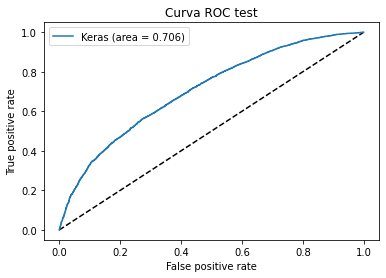

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_hat_prob_sigmoid)
auc_keras = auc(fpr, tpr)
print('auc_keras', auc_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC test')
plt.legend(loc='best')
plt.show()

## 3 - BERT con Fine tuning

In [ ]:
model_bert_2 = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

model_bert_2.compile(tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

history_bert4b = model_bert_2.fit(train_data, epochs=1, validation_data=validation_data)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will a

   2000/Unknown - 2711s 1s/step - loss: 0.2896 - accuracy: 0.8759

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2000/2000 [==============================] - 2826s 1s/step - loss: 0.2896 - accuracy: 0.8759 - val_loss: 0.2540 - val_accuracy: 0.9134


In [ ]:
tf_outputs = model_bert_2.predict(test_inputs)
y_hat_prob = tf.nn.softmax(tf_outputs[0], axis=-1)
y_hat_prob_sigmoid = y_hat_prob[:, 1]

(10000, 2)
(10000, 2)
auc_keras 0.9704147000303498


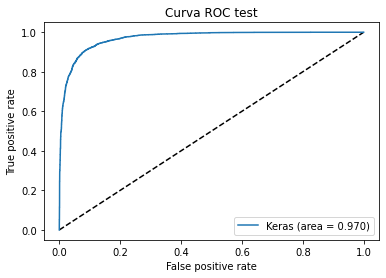

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_hat_prob_sigmoid)
auc_keras = auc(fpr, tpr)
print('auc_keras', auc_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC test')
plt.legend(loc='best')
plt.show()

## Resultados y conclusiones
Tabla de resultados:

| Algorithm                 | RUC Accuracy|
|---------------------------|-------------|
| BOW (OneHotEncoding)  | 0.789  |
| BOW (TFIDF)           | 0.844  |
| Embeddings (Glove)    | 0.789  |
| Embeddings (Fastttext)| 0.843  |
| LSTM                   | 0.875  |
| BERT                   | 0.706  |
| BERT + Fine-Tuning     | 0.970  |

Se puede apreciar que a medida que se utilizaron tecnologías "más mordernas" para la resolución del problema el accuracy fue mejorando. 
- En el caso de los embeddings pre enternados (GLobe y Fasttext) no dió un resultado superador respecto a BOW tradicional debido a que se realizó una promediado de los embeddings para su uso en la red.
- En el caso de LSTM costó bastante poder entrenar la red, hubo que probar bastantes combinaciones hasta dar con la acertada y el resultado se refleja en su accuracy, superando los otros métodos.
- BERT, como era de esperarse, fue superador ampliamente en el proceso de Fine-Tuning. El proceso normal (sin Fine-Tuning) no alcanzó un accuracy sobresaliente, pero tampoco se realizaron demasaidos épocas para ver como podría evolucionar el accuracy (parece que aún podría seguir aprendiendo con más épocas).